<a href="https://colab.research.google.com/github/SWoods356/housing-EDA/blob/main/HousePricesEDA_LinearRegression_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare and Ingest

In [1]:
# load up modules
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
from scipy import stats

# load for visuals
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Figures inline and set visualization style
%matplotlib inline
sns.set()


# Set up notebook to display multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/SWoods356/housing-EDA/main/train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/SWoods356/housing-EDA/main/test.csv')

df.shape
df_test.shape

(1460, 81)

(1459, 80)

## EDA

In [3]:
df.info()

df.dtypes.value_counts()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

object     43
int64      35
float64     3
dtype: int64

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Sale Price Distribution

Text(0.5, 1.0, 'BoxPlot of SalePrice Values')

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

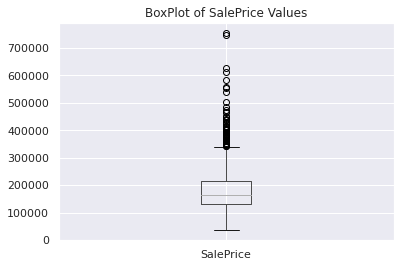

In [4]:

#Get basic statistics and present a boxplot


plt.title("BoxPlot of SalePrice Values")
df.boxplot('SalePrice');

df['SalePrice'].describe()

The IQR for home sales falls between 130,000 and 214,000 with a mean of 180,000. There are 61 outliers above the IQR, with a max of 755,000. A historgram displays this long and heavy right tailed distribution with a skewness of 1.88. The distribution also features a high peak, with a kurtosis of 6.53.

Skew: 1.8828757597682126
Kurtosis: 6.536281860064527


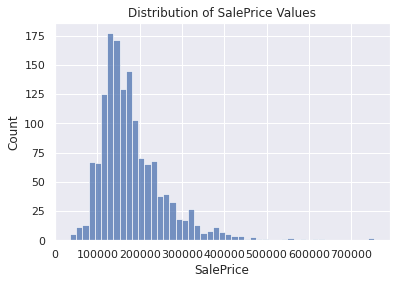

In [5]:
plt.title("Distribution of SalePrice Values");
sns.histplot(df['SalePrice']);

print( 'Skew: {}'.format(skew( df['SalePrice'], bias=False) ));

print( 'Kurtosis: {}'.format(kurtosis( df['SalePrice'], bias=False) ));

With significant skewness and kutosis, we may want to try a log 10 transformation of sale price later.

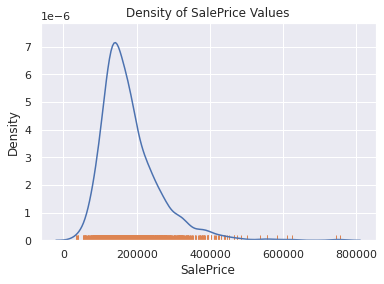

In [6]:
plt.title("Density of SalePrice Values")
sns.kdeplot(df['SalePrice']);
sns.rugplot(df['SalePrice']);


### Investigate Missing Data and Outliers

In [7]:
# Investiagte missing data

df.isnull().sum().sort_values(ascending=False).head(20)
df.isnull().sum().sort_values(ascending=False).head(20)/len(df)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageCond      0.055479
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
Utilities       0.000000
dtype: float64

16 columns featured more than 30 null values, with four columns featuring more than 1,000. Most of these columns have null values because a given house does not have that feature. IE 94% of houses in Ames, Iowa probably do not abut an alley. I could look at the distribution of values of these columns to see if replacing null values with zeros or "false" would make sense.

In [8]:
#look at the distribution of values for columns with a lot of nulls

df["PoolQC"].value_counts()
df["MiscFeature"].value_counts()
df["Alley"].value_counts()
df["Fence"].value_counts()
df["FireplaceQu"].value_counts()
df["LotFrontage"].value_counts()
df["GarageYrBlt"].value_counts()

Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64

Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64

Grvl    50
Pave    41
Name: Alley, dtype: int64

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
106.0      1
38.0       1
138.0      1
140.0      1
137.0      1
Name: LotFrontage, Length: 110, dtype: int64

2005.0    65
2006.0    59
2004.0    53
2003.0    50
2007.0    49
          ..
1908.0     1
1927.0     1
1933.0     1
1900.0     1
1906.0     1
Name: GarageYrBlt, Length: 97, dtype: int64

In [9]:
#look at outliers.

#Get dataframe of only numberic columns
dfnumeric = df._get_numeric_data()

#Establish IQR for numeric df
Q1 = dfnumeric.quantile(0.25)
Q3 = dfnumeric.quantile(0.75)
IQR = Q3 - Q1

#get list of columns with total number of outliers
((dfnumeric < (Q1 - 1.5 * IQR)) | (dfnumeric > (Q3 + 1.5 * IQR))).sum().sort_values(ascending=False)

EnclosedPorch    208
BsmtFinSF2       167
OverallCond      125
ScreenPorch      116
MSSubClass       103
MasVnrArea        96
LotFrontage       88
BsmtHalfBath      82
OpenPorchSF       77
LotArea           69
KitchenAbvGr      68
TotalBsmtSF       61
SalePrice         61
MiscVal           52
BedroomAbvGr      35
WoodDeckSF        32
GrLivArea         31
TotRmsAbvGrd      30
BsmtUnfSF         29
LowQualFinSF      26
3SsnPorch         24
GarageArea        21
1stFlrSF          20
PoolArea           7
YearBuilt          7
BsmtFinSF1         7
Fireplaces         5
GarageCars         5
2ndFlrSF           2
OverallQual        2
BsmtFullBath       1
YearRemodAdd       0
YrSold             0
FullBath           0
HalfBath           0
GarageYrBlt        0
MoSold             0
Id                 0
dtype: int64

17 columns featured more than 30 outliers, with five columns featuring more than 100. Three of those five columns have a lot of outliers because the IQR is zero, indicating most houses again do not have that feature. The overall conditin column seems intuitively related to price, so I would investigate outliers more when building a model. MSSubClass seems like it should be an object data type with numeric codes representing the dwelling type.

In [10]:
#Investigate Columns with more than 100 outliers

df['EnclosedPorch'].describe()
df['BsmtFinSF2'].describe()
df['OverallCond'].describe()
df['ScreenPorch'].describe()
df['MSSubClass'].describe()

count    1460.000000
mean       21.954110
std        61.119149
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       552.000000
Name: EnclosedPorch, dtype: float64

count    1460.000000
mean       46.549315
std       161.319273
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: BsmtFinSF2, dtype: float64

count    1460.000000
mean        5.575342
std         1.112799
min         1.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: OverallCond, dtype: float64

count    1460.000000
mean       15.060959
std        55.757415
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       480.000000
Name: ScreenPorch, dtype: float64

count    1460.000000
mean       56.897260
std        42.300571
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64

### Evaluate Potential Predictors

(<Figure size 864x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faede231510>)

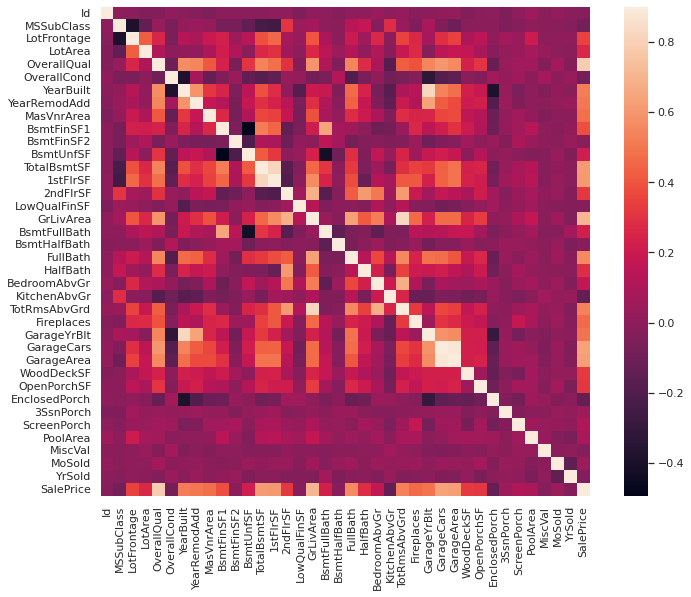

In [11]:
corrmat = df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [12]:
#look at highest correlations

high_corrs = corrmat['SalePrice'].sort_values(ascending=False)

high_corrs

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

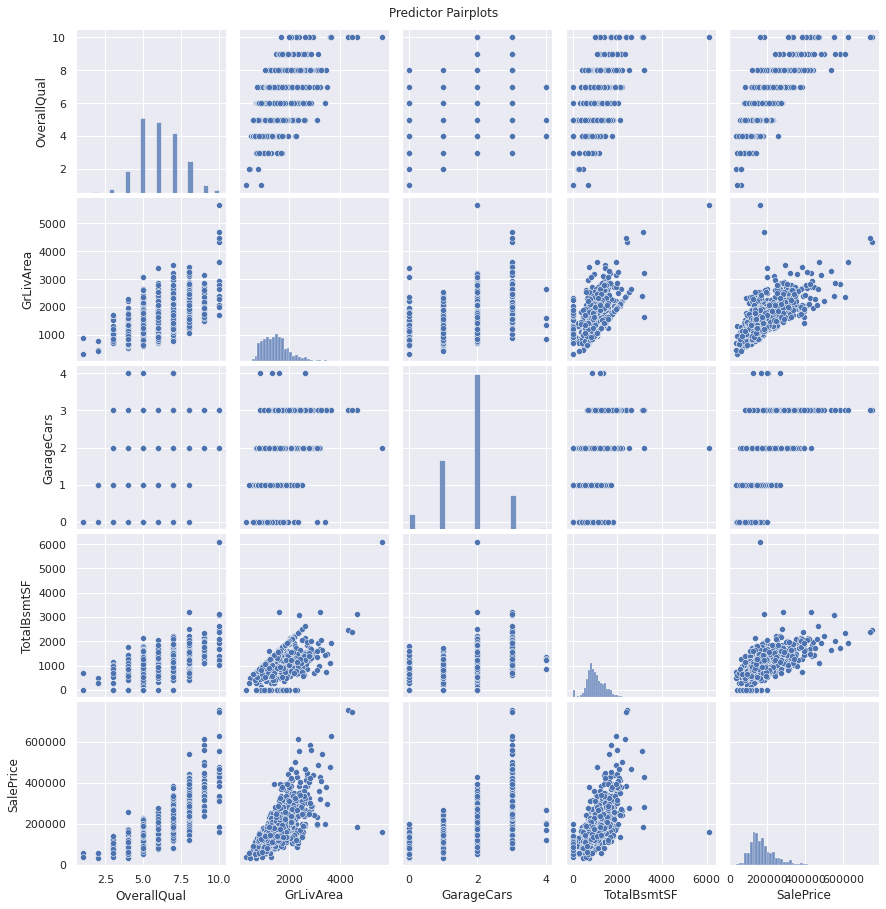

In [13]:
#Selecting four variables to investigate further

predict_df = df[['OverallQual', "GrLivArea", 'GarageCars', "TotalBsmtSF", "SalePrice"]]

pp = sns.pairplot(predict_df, kind="scatter")
pp.fig.suptitle("Predictor Pairplots", y=1.01)

plt.show();

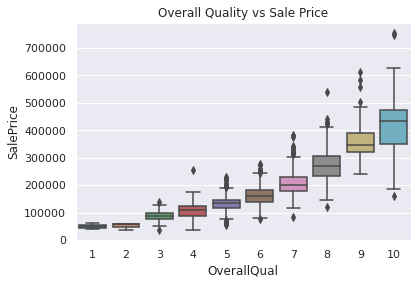

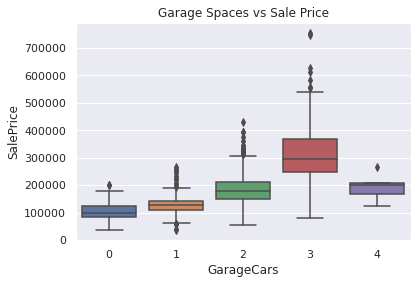

In [14]:
#generate boxplots of columns with discrete distributions

sns.boxplot(x = df['OverallQual'],
y = df['SalePrice'])
plt.title('Overall Quality vs Sale Price')
plt.show();


sns.boxplot(x = df['GarageCars'],
y = df['SalePrice'])
plt.title('Garage Spaces vs Sale Price')
plt.show();

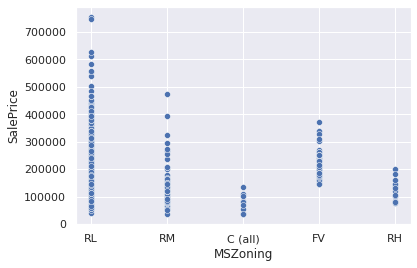

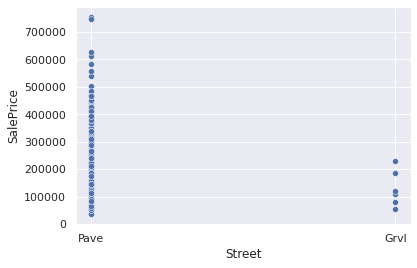

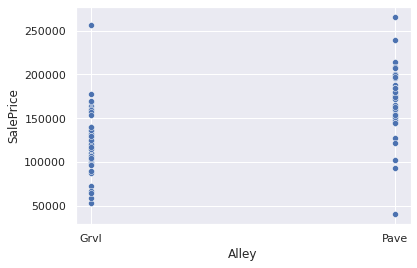

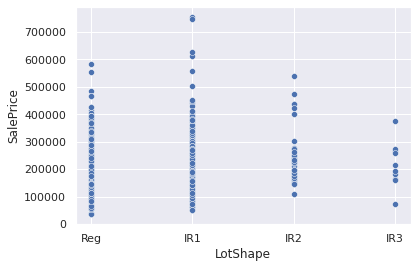

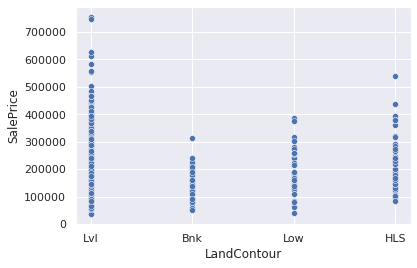

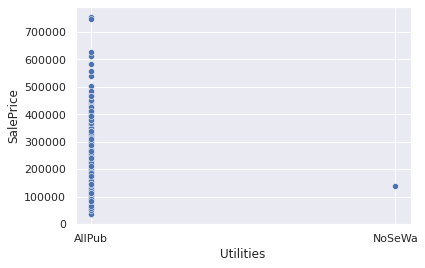

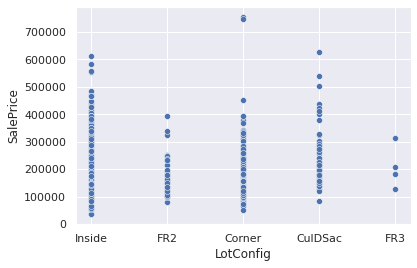

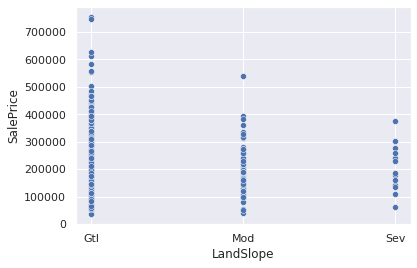

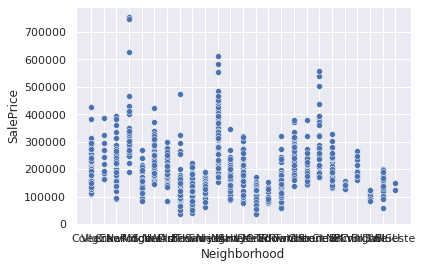

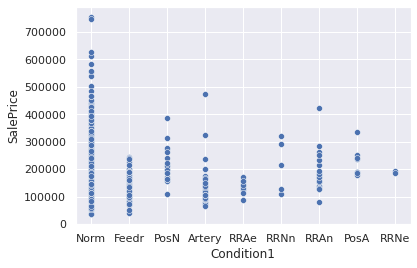

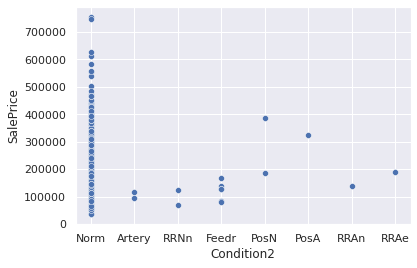

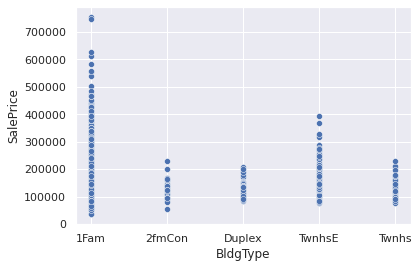

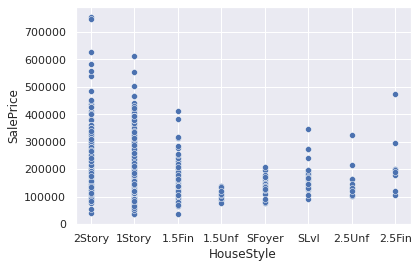

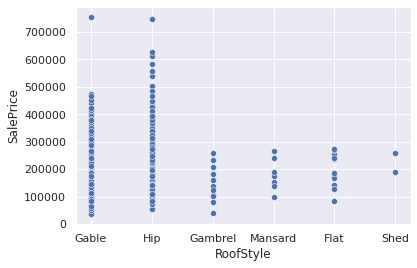

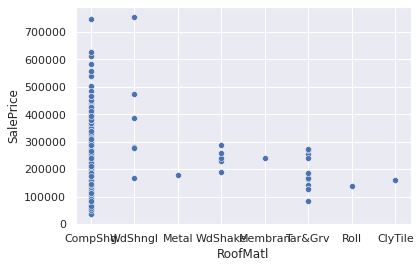

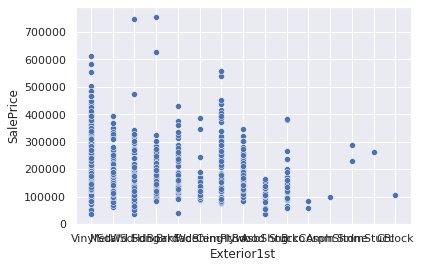

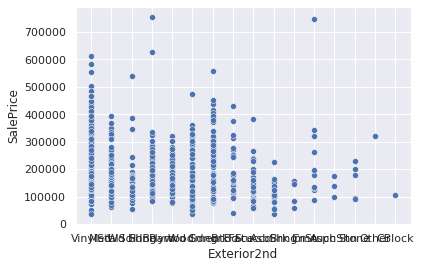

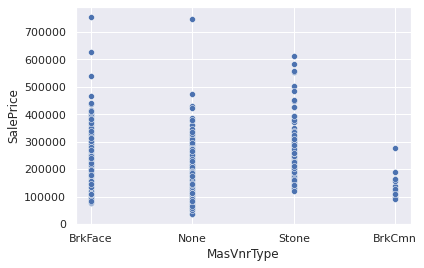

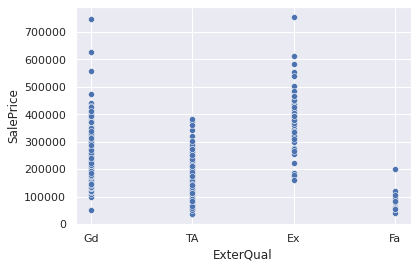

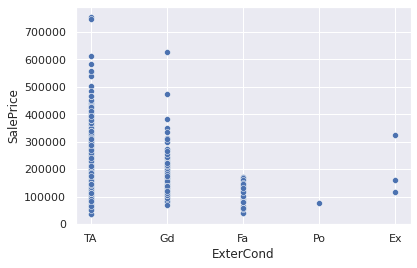

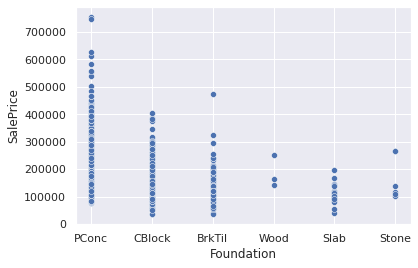

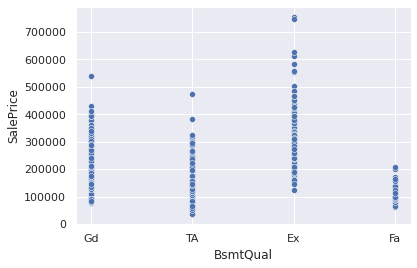

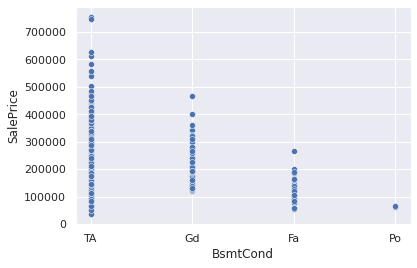

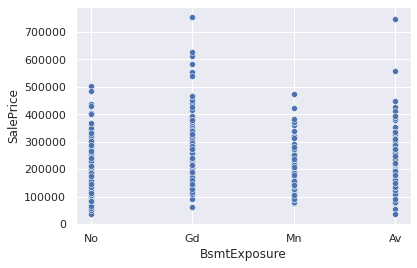

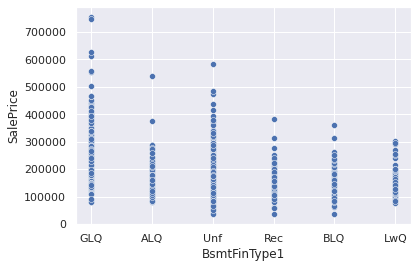

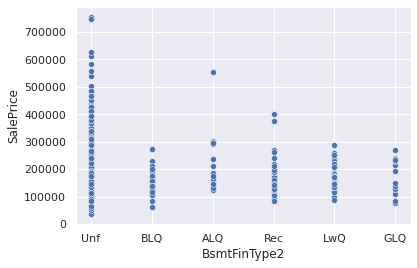

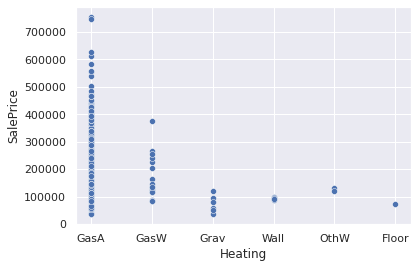

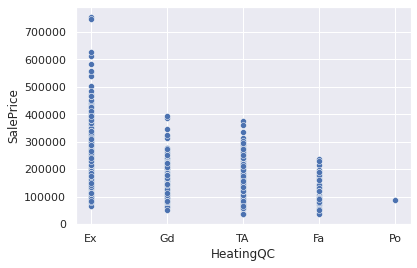

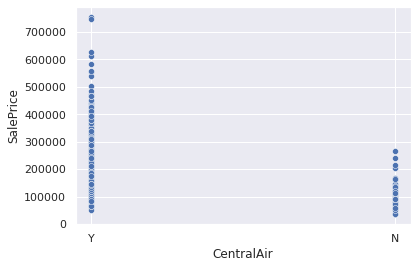

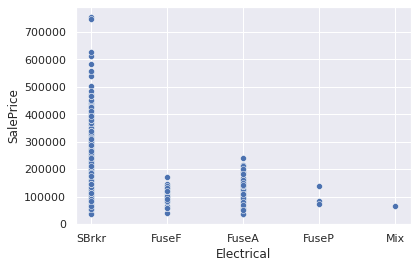

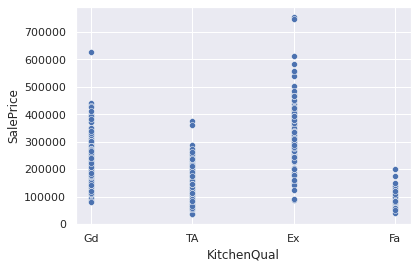

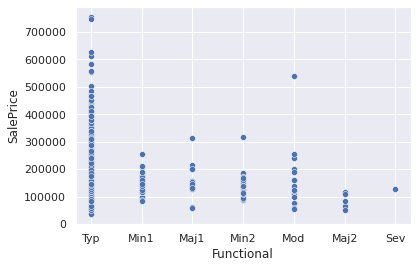

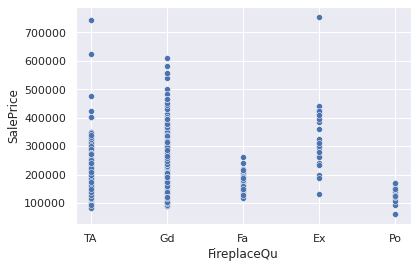

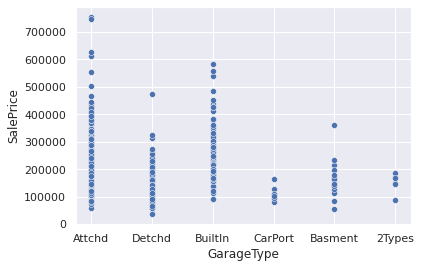

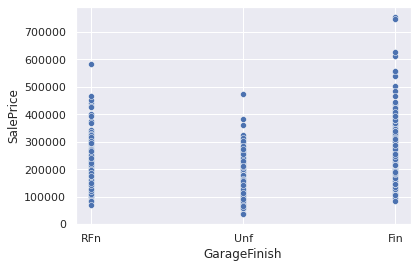

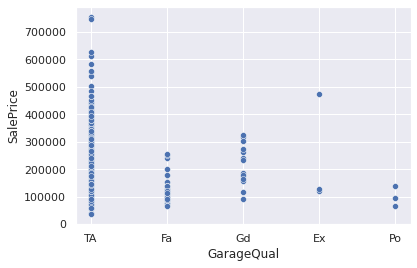

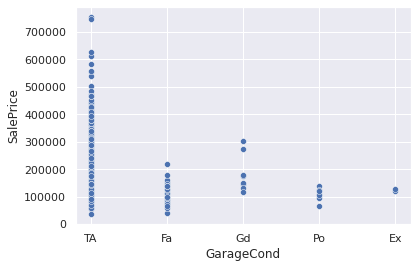

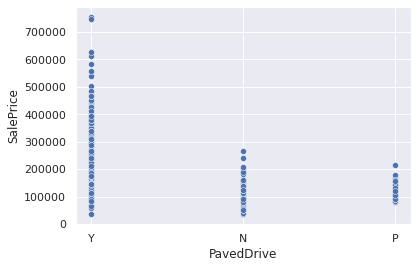

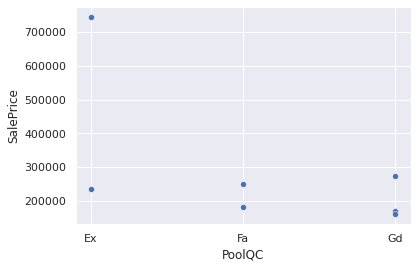

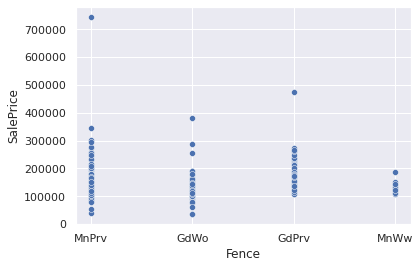

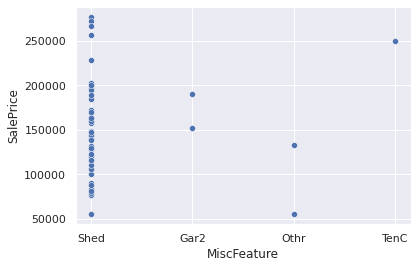

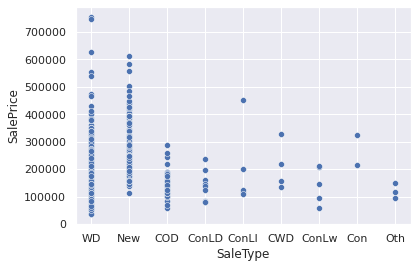

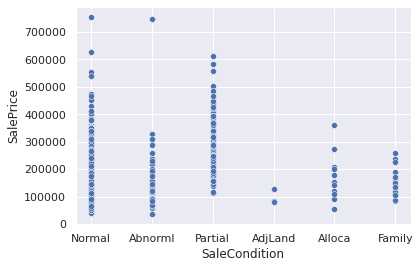

In [15]:
#Generate Plot of all Categorical Columns 

df_cat = df.select_dtypes(include=['object'])

for col in df_cat:
    sns.scatterplot( x = df_cat[col], y = df['SalePrice'])
    plt.show()

Text(0.5, 1.0, 'Exterior1st vs Sale Price')

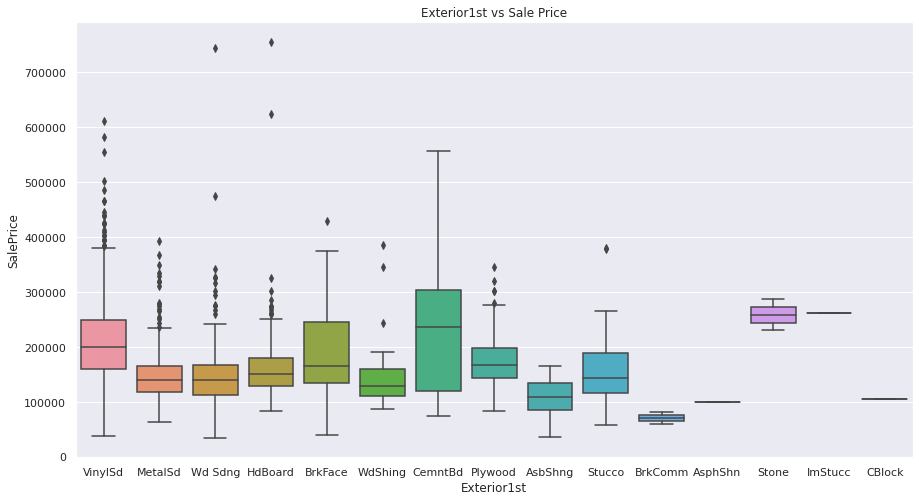

In [16]:
#look at Cateogircal columns that seem related to Sale Price:

f, ax = plt.subplots(figsize = (15,8))

sns.boxplot(x = df['Exterior1st'],
y = df['SalePrice'])
plt.title('Exterior1st vs Sale Price')
plt.show()

Text(0.5, 1.0, 'Exterior Condition vs Sale Price')

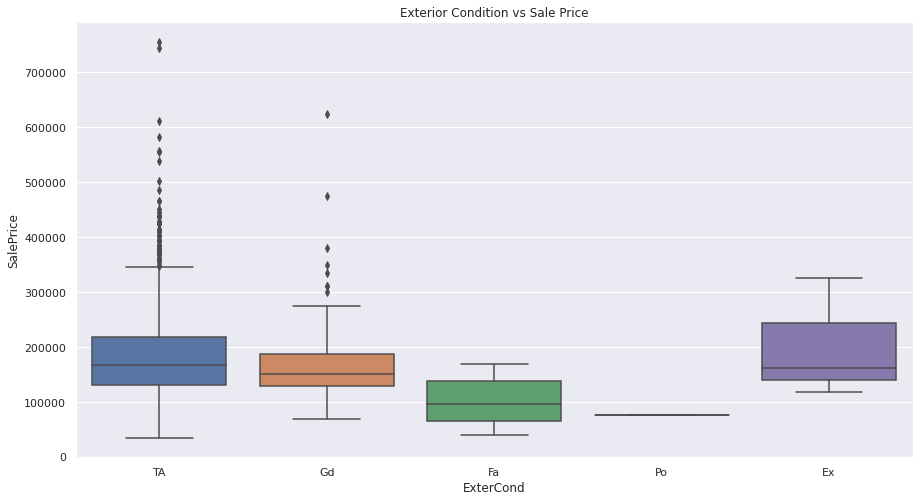

In [17]:
f, ax = plt.subplots(figsize = (15,8))

sns.boxplot(x = df['ExterCond'],
y = df['SalePrice'])
plt.title('Exterior Condition vs Sale Price')
plt.show()

Text(0.5, 1.0, 'Kitchen Quality vs Sale Price')

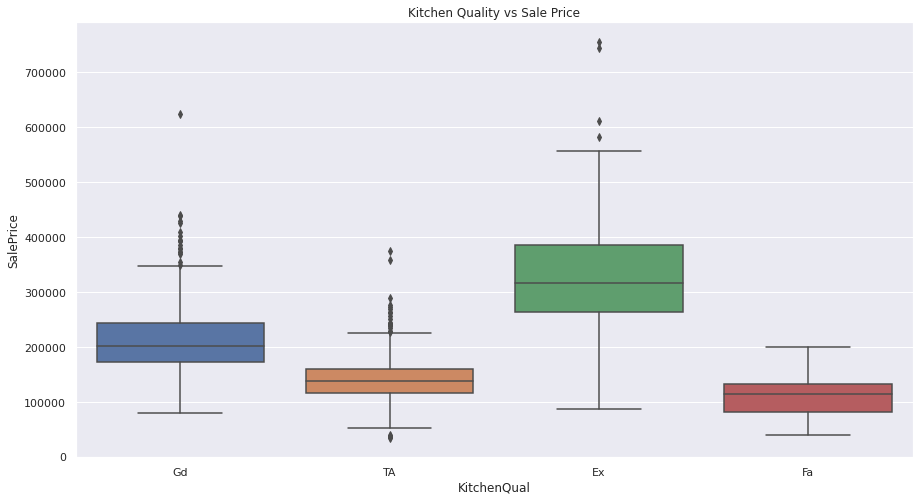

In [18]:
f, ax = plt.subplots(figsize = (15,8))

sns.boxplot(x = df['KitchenQual'],
y = df['SalePrice'])
plt.title('Kitchen Quality vs Sale Price')
plt.show()

## Prepare Data for Modeling

In [19]:
df_train = df

df_train.shape
df_test.shape


#Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

df_train.shape
df_test.shape

(1460, 81)

(1459, 80)

(1460, 80)

(1459, 79)

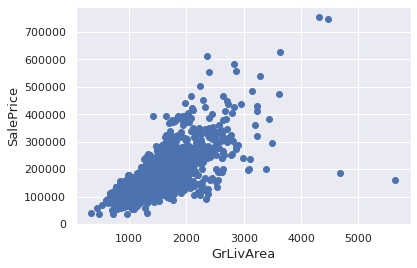

In [20]:
#Look at outliers in GR Living Area

fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show();

Text(0, 0.5, 'SalePrice')

Text(0.5, 0, 'GrLivArea')

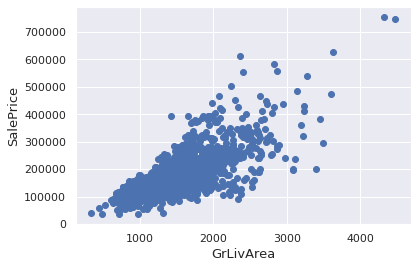

(1458, 80)

In [21]:
#Delete outliers
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)

fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show();

df_train.shape

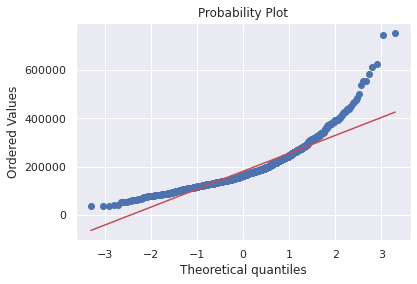

In [22]:
#Do we want to transform SalePrice?
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

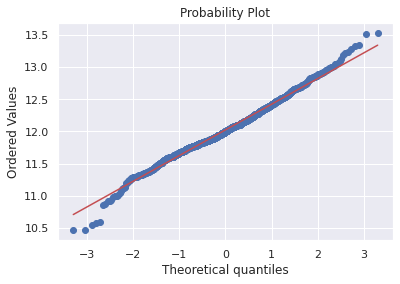

In [23]:
# get log 10 transformation of sale price
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()


I applied a log 10 tranformation to sale price to force sale price closer to that of a normal distribution. This will help promote that residual errors produced by future models are normally distirbuted.

In [24]:
#store sale price
SalePrice_train = df_train.SalePrice

#Combine dfs
df_comb = pd.concat([df_train.drop(['SalePrice'], axis=1), df_test])

df_comb.head()
df_comb.shape

df_comb.dtypes.value_counts()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


(2917, 79)

object     43
int64      25
float64    11
dtype: int64

### Feature Engineering

In [25]:
#add feature score column:
df_numeric = df_comb.select_dtypes(include='number')

df_numeric_std = (df_numeric-df_numeric.mean())/df_numeric.std()


df_numeric_std['feature_score'] = df_numeric_std.sum(axis=1)

df_comb['feature_score'] = df_numeric_std['feature_score']

df_comb.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,feature_score
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,3.646534
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,3.003890
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,7.250127
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,-1.178359
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,21.573324


In [26]:
#Create Total Baths feature
df_comb['total_baths'] = df_comb['FullBath'] + df_comb['BsmtFullBath'] + 0.5 * (df_comb['BsmtHalfBath'] + df_comb['HalfBath'])





In [27]:
#Create Livable Square Foot Feature
df_comb['liveable_sf'] = df_comb['BsmtFinSF1'] + df_comb['BsmtFinSF2'] + df_comb['GrLivArea']

df_comb.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,feature_score,total_baths,liveable_sf
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,...,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,3.646534,3.5,2416.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,...,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,3.003890,2.5,2240.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,...,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,7.250127,3.5,2272.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,...,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,-1.178359,2.0,1933.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,...,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,21.573324,3.5,2853.0


In [28]:
# change nulls to zeros and NAs

# replace null values with "NA" because house does not have that feature for categorical features

df_cat = df_comb.select_dtypes(include='object')

df_cat = df_cat.fillna('NA')


# replace null values with "0" because house does not have that feature for numeric features

df_numeric = df_comb.select_dtypes(include='number')

df_numeric = df_numeric.fillna('0')

df_cat.shape
df_numeric.shape

#Combine into dataframe

df_comb = pd.concat([df_cat, df_numeric.astype(float)], axis=1, join='inner')

df_comb.head()


df_comb.dtypes.value_counts()

(2917, 43)

(2917, 39)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,...,SaleCondition,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,feature_score,total_baths,liveable_sf
0,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NA,Attchd,RFn,TA,TA,Y,NA,NA,...,Normal,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,3.646534,3.5,2416.0
1,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,...,Normal,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,6.0,1.0,1976.0,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,3.003890,2.5,2240.0
2,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,...,Normal,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,6.0,1.0,2001.0,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,7.250127,3.5,2272.0
3,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NA,NA,...,Abnorml,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,7.0,1.0,1998.0,3.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,-1.178359,2.0,1933.0
4,RL,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,...,Normal,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,9.0,1.0,2000.0,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,21.573324,3.5,2853.0


object     43
float64    39
dtype: int64

In [29]:
#Transform discrete numeric features to to categorical features
df_comb['MSSubClass'] = df_comb['MSSubClass'].apply(str)
df_comb['OverallCond'] = df_comb['OverallCond'].apply(str)

df_comb['ExterCond'].value_counts()


TA    2536
Gd     299
Fa      67
Ex      12
Po       3
Name: ExterCond, dtype: int64

In [30]:
# Encode Categorical Variables that have order

#Have to assign correct number manually as label encoder does not do this:
order_dict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}

#Loop to map dictionairy to the below categorical columns that have order:

#for col in df_comb[["ExterQual", "ExterCond", "HeatingQC", "KitchenQual", "BsmtQual", 
              # "BsmtCond", "FireplaceQu", "GarageQual", "GarageCond"]]:
 # df_comb[col] = df_comb[col].map(order_dict)


# shape        
df_comb.shape

df_comb.head()

df_comb['ExterCond'].value_counts()

df_comb.dtypes.value_counts()

(2917, 82)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,...,SaleCondition,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,feature_score,total_baths,liveable_sf
0,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NA,Attchd,RFn,TA,TA,Y,NA,NA,...,Normal,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,3.646534,3.5,2416.0
1,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,...,Normal,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,6.0,1.0,1976.0,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,3.003890,2.5,2240.0
2,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,...,Normal,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,6.0,1.0,2001.0,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,7.250127,3.5,2272.0
3,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NA,NA,...,Abnorml,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,7.0,1.0,1998.0,3.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,-1.178359,2.0,1933.0
4,RL,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,...,Normal,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,9.0,1.0,2000.0,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,21.573324,3.5,2853.0


TA    2536
Gd     299
Fa      67
Ex      12
Po       3
Name: ExterCond, dtype: int64

object     45
float64    37
dtype: int64

Apply standard scaling to numeric (float64) columns

In [31]:

# Get Numeric Column Names, excluding former categorical columns that were encoded with numers
df_numeric = df_comb.select_dtypes(include='float64')

num_cols = df_numeric.columns

num_cols


Index(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
       'feature_score', 'total_baths', 'liveable_sf'],
      dtype='object')

In [32]:
#Scale Numeric Columns
scaler = StandardScaler()

df_comb[['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
       'feature_score', 'total_baths', 'liveable_sf']] = scaler.fit_transform(df_comb[['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
       'feature_score', 'total_baths', 'liveable_sf']])

#df_comb = pd.DataFrame(standard_np, columns= df_comb.columns)

df_comb.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,...,SaleCondition,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,feature_score,total_baths,liveable_sf
0,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NA,Attchd,RFn,TA,TA,Y,NA,NA,...,Normal,60.0,0.221752,-0.216437,0.649580,5.0,1.047231,0.897702,0.534087,0.601514,-0.293134,-0.933762,-0.449391,-0.783214,1.210473,-0.101232,0.426204,1.090257,-0.249810,0.783237,1.233664,0.169987,-0.207773,0.992279,-0.924763,0.295120,0.307738,0.352788,-0.740089,0.204447,-0.359740,-0.103366,-0.286041,-0.060447,-0.089623,-1.553332,0.157449,0.295567,1.589615,0.583709
1,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,...,Normal,20.0,0.674581,-0.069108,-0.061424,8.0,0.155606,-0.394865,-0.567024,1.213983,-0.293134,-0.628956,0.496118,0.270789,-0.784638,-0.101232,-0.475524,-0.818675,3.821109,0.783237,-0.755611,0.169987,-0.207773,-0.286483,0.626435,0.235086,0.307738,-0.057038,1.615438,-0.704543,-0.359740,-0.103366,-0.286041,-0.060447,-0.089623,-0.447384,-0.602948,0.243478,0.352282,0.344568
2,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,...,Normal,60.0,0.312318,0.142276,0.649580,5.0,0.981185,0.849829,0.343078,0.106135,-0.293134,-0.287754,-0.300345,-0.617065,1.238507,-0.101232,0.579176,1.090257,-0.249810,0.783237,1.233664,0.169987,-0.207773,-0.286483,0.626435,0.290673,0.307738,0.632214,-0.740089,-0.078681,-0.359740,-0.103366,-0.286041,-0.060447,-0.089623,1.027214,0.157449,0.587653,1.589615,0.388048
3,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NA,NA,...,Abnorml,70.0,0.070809,-0.075514,0.649580,5.0,-1.858805,-0.682102,-0.567024,-0.501830,-0.293134,-0.046639,-0.682275,-0.510627,0.981526,-0.101232,0.440294,1.090257,-0.249810,-1.027145,-0.755611,0.169987,-0.207773,0.352898,0.626435,0.284003,1.620124,0.790556,-0.740089,-0.182991,3.873564,-0.103366,-0.286041,-0.060447,-0.089623,-1.553332,-1.363345,-0.095511,-0.266385,-0.072569
4,RL,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,...,Normal,60.0,0.795336,0.527891,1.360583,5.0,0.948161,0.754083,1.399246,0.486676,-0.293134,-0.160373,0.223644,-0.032951,1.675376,-0.101232,1.408445,1.090257,-0.249810,0.783237,1.233664,1.385311,-0.207773,1.631660,0.626435,0.288449,1.620124,1.694035,0.777566,0.547181,-0.359740,-0.103366,-0.286041,-0.060447,-0.089623,2.133162,0.157449,1.748607,1.589615,1.177484


Encode Dummy Variables for remaining categoricals

In [33]:
df_comb = pd.get_dummies(df_comb, drop_first=True)

df_comb.head()
df_comb.shape

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,feature_score,total_baths,liveable_sf,MSZoning_FV,MSZoning_NA,MSZoning_RH,...,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_NA,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_150.0,MSSubClass_160.0,MSSubClass_180.0,MSSubClass_190.0,MSSubClass_20.0,MSSubClass_30.0,MSSubClass_40.0,MSSubClass_45.0,MSSubClass_50.0,MSSubClass_60.0,MSSubClass_70.0,MSSubClass_75.0,MSSubClass_80.0,MSSubClass_85.0,MSSubClass_90.0,OverallCond_2.0,OverallCond_3.0,OverallCond_4.0,OverallCond_5.0,OverallCond_6.0,OverallCond_7.0,OverallCond_8.0,OverallCond_9.0
0,0.221752,-0.216437,0.649580,1.047231,0.897702,0.534087,0.601514,-0.293134,-0.933762,-0.449391,-0.783214,1.210473,-0.101232,0.426204,1.090257,-0.249810,0.783237,1.233664,0.169987,-0.207773,0.992279,-0.924763,0.295120,0.307738,0.352788,-0.740089,0.204447,-0.359740,-0.103366,-0.286041,-0.060447,-0.089623,-1.553332,0.157449,0.295567,1.589615,0.583709,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.674581,-0.069108,-0.061424,0.155606,-0.394865,-0.567024,1.213983,-0.293134,-0.628956,0.496118,0.270789,-0.784638,-0.101232,-0.475524,-0.818675,3.821109,0.783237,-0.755611,0.169987,-0.207773,-0.286483,0.626435,0.235086,0.307738,-0.057038,1.615438,-0.704543,-0.359740,-0.103366,-0.286041,-0.060447,-0.089623,-0.447384,-0.602948,0.243478,0.352282,0.344568,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.312318,0.142276,0.649580,0.981185,0.849829,0.343078,0.106135,-0.293134,-0.287754,-0.300345,-0.617065,1.238507,-0.101232,0.579176,1.090257,-0.249810,0.783237,1.233664,0.169987,-0.207773,-0.286483,0.626435,0.290673,0.307738,0.632214,-0.740089,-0.078681,-0.359740,-0.103366,-0.286041,-0.060447,-0.089623,1.027214,0.157449,0.587653,1.589615,0.388048,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0.070809,-0.075514,0.649580,-1.858805,-0.682102,-0.567024,-0.501830,-0.293134,-0.046639,-0.682275,-0.510627,0.981526,-0.101232,0.440294,1.090257,-0.249810,-1.027145,-0.755611,0.169987,-0.207773,0.352898,0.626435,0.284003,1.620124,0.790556,-0.740089,-0.182991,3.873564,-0.103366,-0.286041,-0.060447,-0.089623,-1.553332,-1.363345,-0.095511,-0.266385,-0.072569,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,0.795336,0.527891,1.360583,0.948161,0.754083,1.399246,0.486676,-0.293134,-0.160373,0.223644,-0.032951,1.675376,-0.101232,1.408445,1.090257,-0.249810,0.783237,1.233664,1.385311,-0.207773,1.631660,0.626435,0.288449,1.620124,1.694035,0.777566,0.547181,-0.359740,-0.103366,-0.286041,-0.060447,-0.089623,2.133162,0.157449,1.748607,1.589615,1.177484,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


(2917, 291)

In [34]:
# Re split training and testing data

x_train = df_comb.iloc[:df_train.shape[0]]
x_test = df_comb[df_train.shape[0]:]
y_train = SalePrice_train 

#train should have two fewer rows than original df because we removed two outliers
x_train.shape
x_test.shape

(1458, 291)

(1459, 291)

## Modeling

In [35]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(x_train, y_train)

coeff_df = pd.DataFrame(model.coef_, x_train.columns, columns=['Coefficient'])


LinearRegression()

In [36]:
# Get P Values of Coefficients
import statsmodels.api as sm

x = sm.add_constant(x_train)

model_get_pvalues = sm.OLS(y_train, x)
model_OLS = model_get_pvalues.fit()
print(model_OLS.summary())

coeff_df['p_values'] = model_OLS.pvalues



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     85.31
Date:                Sun, 23 Jan 2022   Prob (F-statistic):               0.00
Time:                        18:58:17   Log-Likelihood:                 1470.4
No. Observations:                1458   AIC:                            -2397.
Df Residuals:                    1186   BIC:                            -959.3
Df Model:                         271                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.70

In [37]:
#predict values for the training dataset and evaluate goodness of fit
from sklearn.metrics import mean_squared_error
import math

y_train_pred = model.predict(x_train)

MSE = mean_squared_error(y_train, y_train_pred)

RMSE = math.sqrt(MSE)

print("Root Mean Squared Error = {:.8f}".format(RMSE))

Root Mean Squared Error = 0.08826402


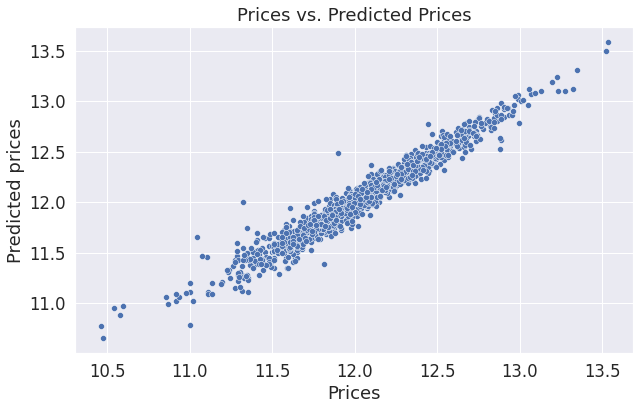

In [38]:
#Plot Predicted Prices vs Actual Prices

sns.set(font_scale=1.5)
plt.figure(figsize=(10,6))
sns.scatterplot(x = y_train, y = y_train_pred);
plt.xlabel("Prices");
plt.ylabel("Predicted prices");
plt.title("Prices vs. Predicted Prices");

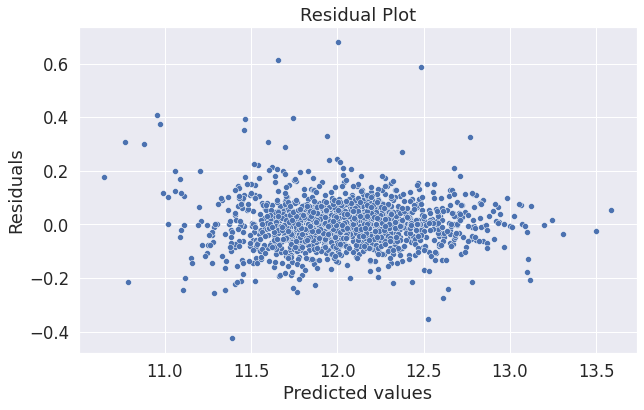

In [39]:
# Residual plot - result should be randomly located around the 0 value
plt.figure(figsize=(10,6))
sns.scatterplot(x = y_train_pred,y =  y_train_pred - y_train);
plt.title("Residual Plot");
plt.xlabel("Predicted values");
plt.ylabel("Residuals");

This plot of residuals (predicted less actual sale prices) of my linear regression model does not reveal any clear shape or trend. This indicates there is a fair amount of equality of variance between features, adhering to basic linear regression assumptions. Sale price was log 10 transformed. The below histogram does reflect a high peak, just as the Sale Price variable does. Before log 10 transforming sale price and running this same model, there was a clear trend in this residual plot. 

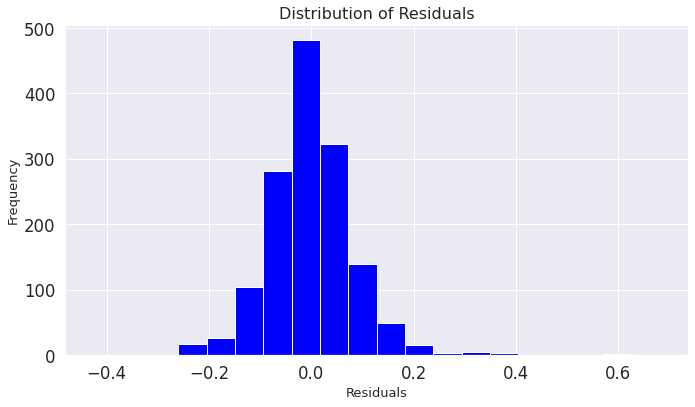

In [40]:
(y_train_pred - y_train).hist(bins = 20, figsize = (10,6), color = 'blue')
plt.title('Distribution of Residuals', fontdict = {'fontsize':16})
plt.xlabel('Residuals', fontdict = {'fontsize':13})
plt.ylabel('Frequency', fontdict = {'fontsize':13})
plt.tight_layout();

In [41]:
# Make Y Predictions and Prepare for Submission

#Remember to reverse log 10 transformation of sale price with np.expm1

pred1 = np.expm1(model.predict(x_test))

submit = pd.DataFrame()

submit['Id'] = test_ID
submit['SalePrice'] = pred1

submit.to_csv('submission2.csv',index=False)

submit.head()

submit.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning:

overflow encountered in expm1



,Id,SalePrice
0,1461,119114.745680
1,1462,173380.985665
2,1463,182809.993644
3,1464,201188.737186
4,1465,195439.459101


(1459, 2)

Implement cross validation and other regression techniques to see how RMSE changes.

In [42]:
# Use cross validation and paramter tuning
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LassoLarsIC, SGDRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

#define cross validation set up

n_folds = 6

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train.values)
    rmse= (cross_val_score(model, x_train.values, y_train, scoring="neg_root_mean_squared_error", cv = kf))
    return(np.mean(rmse))


In [43]:
#Try different linear models and select the best performing model for next submission


lr_model = LinearRegression()

#best performing
lasso_model = Lasso(alpha =0.0005, random_state=1)


rr_model = Ridge(alpha =1, solver="cholesky")

en_model = ElasticNet(alpha =.01, l1_ratio=.5)


lr_rmsle = rmsle_cv(lr_model)
lass_rmsle = rmsle_cv(lasso_model)
rr_rmsle = rmsle_cv(rr_model)
en_rmsle = rmsle_cv(en_model)

print("Linear Root Mean Squared Error = {:.8f}".format(lr_rmsle))
print("Lasso Root Mean Squared Error = {:.8f}".format(lass_rmsle))
print("Ridge Root Mean Squared Error = {:.8f}".format(rr_rmsle))
print("Elastic Net Root Mean Squared Error = {:.8f}".format(en_rmsle))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.141e-02, tolerance: 1.950e-02

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.281e-02, tolerance: 1.915e-02

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.951e-02, tolerance: 1.852e-02

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent

Linear Root Mean Squared Error = -2755528753.22732830
Lasso Root Mean Squared Error = -0.11364195
Ridge Root Mean Squared Error = -0.11698308
Elastic Net Root Mean Squared Error = -0.13281391


The lasso regression model got the best score, so let's predict and submit with that model.

In [44]:
#Evaluate fit of rr model on trainig data

#fit to training data
lasso_model.fit(x_train, y_train)

#predict values for the training dataset and evaluate goodness of fit
y_train_pred_lasso = lasso_model.predict(x_train)

# Calc RMSE
MSE_lasso = mean_squared_error(y_train, y_train_pred_lasso)

RMSE_lasso = math.sqrt(MSE_lasso)

print("Mean Squared Error = {:.8f}".format(RMSE_lasso))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.673e-02, tolerance: 2.328e-02



Lasso(alpha=0.0005, random_state=1)

Mean Squared Error = 0.10194039


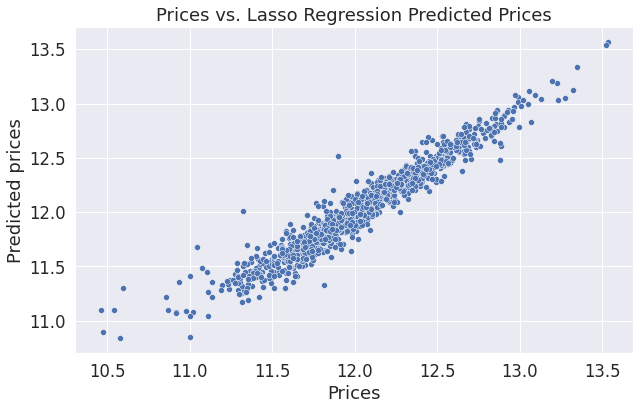

In [45]:
#Plot Predicted Prices vs Actual Prices

sns.set(font_scale=1.5)
plt.figure(figsize=(10,6))
sns.scatterplot(x = y_train, y = y_train_pred_lasso)
plt.xlabel("Prices");
plt.ylabel("Predicted prices");
plt.title("Prices vs. Lasso Regression Predicted Prices");

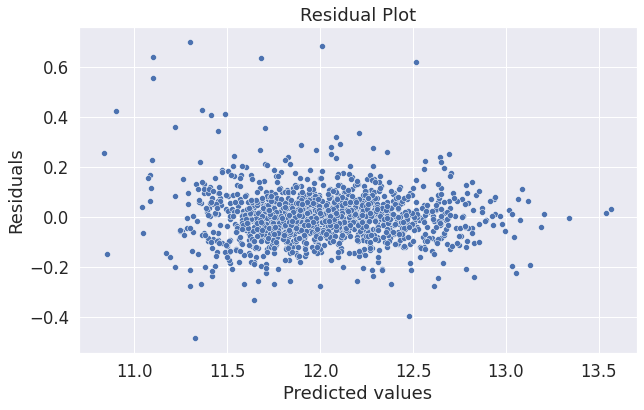

In [46]:
# Residual plot - result should be randomly located around the 0 value
plt.figure(figsize=(10,6))
sns.scatterplot(x = y_train_pred_lasso, y = y_train_pred_lasso - y_train);
plt.title("Residual Plot");
plt.xlabel("Predicted values");
plt.ylabel("Residuals");

This plot of residuals using lasso regression only has small differences compared to the residual plot from my base linear regression model shown earlier. Again, no clear trend is evident.

In [61]:
# Make Y Predictions and Prepare for Submission

lasso_model = lasso_model.fit(x_train, y_train)

#Remember to reverse log 10 transformation of sale price with np.expm1

pred1 = np.expm1(lasso_model.predict(x_test))

submit = pd.DataFrame()

submit['Id'] = test_ID
submit['SalePrice'] = pred1

submit.to_csv('submission9.csv',index=False)

submit.head()

submit.shape

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.673e-02, tolerance: 2.328e-02



,Id,SalePrice
0,1461,112981.553680
1,1462,155617.369840
2,1463,178578.294032
3,1464,199970.580451
4,1465,193424.107984


(1459, 2)

###Model Summary

Below is a summary of the top three models that I produced.

In [48]:


rmsle_model = ['Linear', 'Lasso', 'Ridge']

rmsle_scores = [-0.123443, -0.123178, -0.123236]

kaggle_scores = [.14113, .13917, .14085]





summary_df = pd.DataFrame(list(zip(rmsle_model, rmsle_scores, kaggle_scores)))

summary_df.columns = ['Model', 'RMSLE', 'Kaggle Score']

summary_df


,Model,RMSLE,Kaggle Score
0,Linear,-0.123443,0.14113
1,Lasso,-0.123178,0.13917
2,Ridge,-0.123236,0.14085


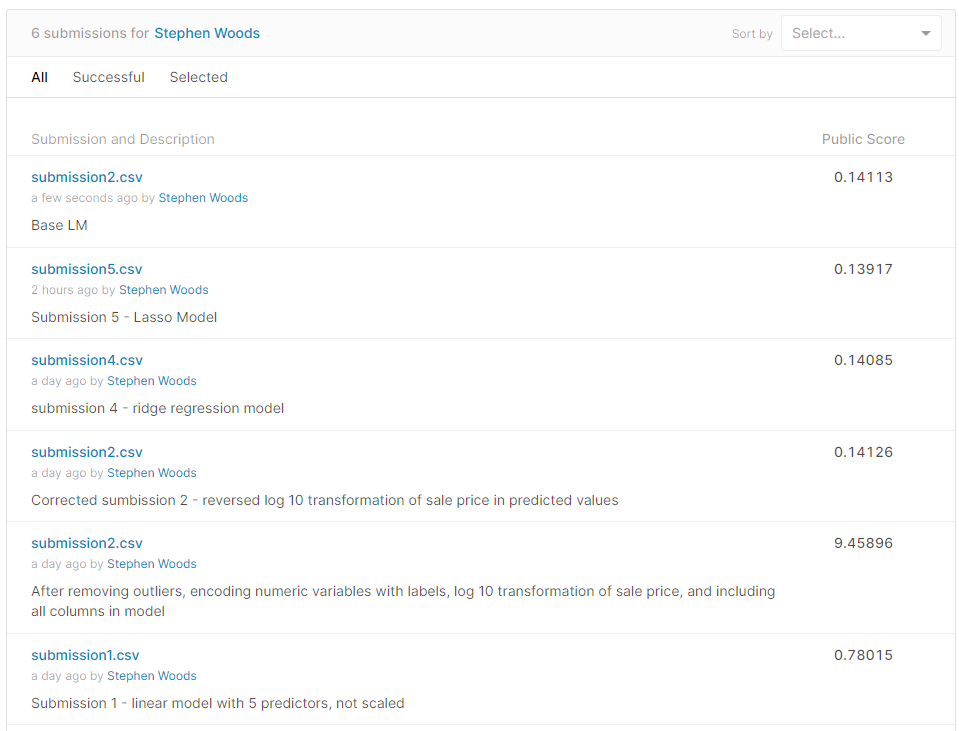

In [49]:
coeff_df.sort_values('Coefficient', ascending=False).head(15)

,Coefficient,p_values
FullBath,5.161889e+10,1.676374e-01
BsmtFullBath,4.895402e+10,9.157917e-02
MSZoning_NA,4.653915e+10,3.242119e-09
2ndFlrSF,2.432210e+10,2.964707e-04
HalfBath,2.348843e+10,5.247835e-01
1stFlrSF,2.188742e+10,6.281542e-03
BsmtFinSF1,1.897687e+10,2.010715e-02
BsmtHalfBath,1.147774e+10,1.196994e-02
BsmtUnfSF,7.259745e+09,5.613948e-01
BsmtFinSF2,7.230159e+09,1.742570e-01


Features that seemed intuitively related to sale price, such as pool quality, overall quality, overall condition, and garage car spaces each had relatively large coefficients in my linear model. Street had the largest coefficient in my linear model. Given nearly all houses had "paved" street access, this variable should be dropped for future models as the related value is more reflective of an intercept for my model. 

Overall, 6 fold cross validation was implemented to evaluate linear, ridge, and lasso regression models. Each model produced an RMSLE within .004 of one another, and the Lasso regression model performed the best on the Kaggle test set. Both lasso and ridge regression performed better than the base linear regression model, indicating overfitting may have been reduced. Robost scaling was also used for each model to limit sensitivity to outliers.

In [50]:
df_train['Street'].value_counts()

Pave    1452
Grvl       6
Name: Street, dtype: int64

In [51]:

#tune Elastic Net Model

from sklearn import preprocessing

# scale with robust scaler
scaler = preprocessing.RobustScaler()
robust_x_train = scaler.fit_transform(x_train)


#Tune Elastic Net model
from sklearn.linear_model import ElasticNetCV
enet_alphas = [0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0]
enet_ratios = np.arange(0, 1, 0.01)
enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratios, cv=6)
enet_model = enet_model.fit(x_train, y_train)

optimal_alpha = enet_model.alpha_
optimal_ratio = enet_model.l1_ratio_

optimal_alpha
optimal_ratio



Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.498700467055471, tolerance: 0.01949873919495081

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04196066969089429, tolerance: 0.019152551001454087

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: UserWarning:

Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.419104209776407, tolerance: 0.01915255100145408

0.001

0.25

In [52]:
optimal_alpha

0.001

In [53]:
optimal_ratio

0.25

In [54]:
#Fit Enet Model with Optimal Values

en_model = make_pipeline(RobustScaler(), ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_ratio))

en_rmsle = rmsle_cv(en_model)

print("Elastic Net Root Mean Squared Error = {:.8f}".format(en_rmsle))

Elastic Net Root Mean Squared Error = -0.11330128


In [55]:
#Pick a scoring method to go with, this or the pipe function
ypred = enet_model.predict(x_train)
score = model.score(x_train, y_train)
mse = mean_squared_error(y_train, ypred)
print("R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.8f}"
      .format(score, mse, np.sqrt(mse)))

R2:0.951, MSE:0.01, RMSE:0.09770215


In [56]:
# This is slightly higher than my lasso_model. Lets submit predictions to kaggle
print("Elastic Net Root Mean Squared Error = {:.8f}".format(en_rmsle))

Elastic Net Root Mean Squared Error = -0.11330128


In [59]:
# Make Y Predictions and Prepare for Submission

en_model = en_model.fit(x_train, y_train)

#Remember to reverse log 10 transformation of sale price with np.expm1

pred1 = np.expm1(en_model.predict(x_test))

submit = pd.DataFrame()

submit['Id'] = test_ID
submit['SalePrice'] = pred1

submit.to_csv('submission8.csv',index=False)

submit.head()

submit.shape

,Id,SalePrice
0,1461,114551.349709
1,1462,155329.344101
2,1463,179629.068830
3,1464,199682.419130
4,1465,193965.048203


(1459, 2)

In [73]:

#en_row = pd.Series(['Elastic_Net', -.12316117, .14036], index = summary_df.columns)
#summary_df = summary_df.append(en_row, ignore_index=True)

#ridge_roww = pd.Series(['ridge_Format2', -0.113992, 0.13307], index = summary_df.columns)
#summary_df = summary_df.append(ridge_roww, ignore_index=True)


#summary_df = summary_df.drop(summary_df.index[-3:])

summary_df

,Model,RMSLE,Kaggle Score
0,Linear,-0.123443,0.14113
1,Lasso,-0.123178,0.13917
2,Ridge,-0.123236,0.14085
3,Elastic_Net,-0.123161,0.14036
4,Elastic_Net_Format2,-0.113301,0.13314
5,Lasso_Format2,-0.113642,0.13437
6,ridge_Format2,-0.113992,0.13307


While the tuned Elastic Net model had the best RMSLE score, it performed second best on the Kaggle test set.

Format 2 Submissions: A second round of data formatting was done to 1) apply a manual ranking categorical columns with order, 2) transform the remaining categorical columns to dummy variables, and 3) standardize all numeric columns.

Format 2 submission performed better than previous submissions. Tuning the elastic net model resulted in the same alpha value (.001) but a different ratio (.25). The tuned elastic net model performed better than the un tuned lasso model. 


In [68]:
#Tune Ridge Model

from sklearn.linear_model import RidgeCV
ridge_alphas = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1.0, 10.0, 100.0]

ridge_model = RidgeCV(alphas=ridge_alphas, cv=6)
ridge_model = ridge_model.fit(x_train, y_train)

optimal_ridge_alpha = ridge_model.alpha_


optimal_ridge_alpha



10.0

In [70]:
#Fit Ridge Model with Optimal Values

ridge_model_tuned = Ridge(alpha=optimal_ridge_alpha)

rmsle_cv(ridge_model_tuned)

-0.11399230699596435

In [78]:
ypred = ridge_model_tuned.predict(x_train)
score = model.score(x_train, y_train)
mse = mean_squared_error(y_train, ypred)
print("R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.8f}"
      .format(score, mse, np.sqrt(mse)))

R2:0.951, MSE:0.01, RMSE:0.09694546


In [72]:
# Make Y Predictions and Prepare for Submission

ridge_model_tuned = ridge_model_tuned.fit(x_train, y_train)

#Remember to reverse log 10 transformation of sale price with np.expm1

pred1 = np.expm1(ridge_model_tuned.predict(x_test))

submit = pd.DataFrame()

submit['Id'] = test_ID
submit['SalePrice'] = pred1

submit.to_csv('submission10.csv',index=False)

submit.head()

submit.shape

,Id,SalePrice
0,1461,114827.362030
1,1462,157303.245665
2,1463,179798.028037
3,1464,199325.292107
4,1465,193041.495813


(1459, 2)

In [74]:
# Tune Lasso Model

from sklearn.linear_model import LassoCV
lasso_alphas = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1.0, 5, 10.0, 25, 50, 75, 100.0]

lasso_model = LassoCV(alphas=lasso_alphas, cv=6)
lasso_model = lasso_model.fit(x_train, y_train)

optimal_lasso_alpha = lasso_model.alpha_


optimal_lasso_alpha


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.242e-02, tolerance: 2.328e-02



0.0001

The first lasso model used an alpha of .0005, lets see if .0001 makes a difference

In [75]:
#Fit Lasso Model with Optimal Values

lasso_model_tuned = Lasso(alpha=optimal_lasso_alpha)

rmsle_cv(lasso_model_tuned)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.565e-02, tolerance: 1.950e-02

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.613e-02, tolerance: 1.915e-02

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.380e-02, tolerance: 1.852e-02

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent

-0.11521285260944958

In [76]:
# Make Y Predictions and Prepare for Submission

lasso_model_tuned = lasso_model_tuned.fit(x_train, y_train)

#Remember to reverse log 10 transformation of sale price with np.expm1

pred1 = np.expm1(lasso_model_tuned.predict(x_test))

submit = pd.DataFrame()

submit['Id'] = test_ID
submit['SalePrice'] = pred1

submit.to_csv('submission11.csv',index=False)

submit.head()

submit.shape

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.242e-02, tolerance: 2.328e-02



,Id,SalePrice
0,1461,117851.810871
1,1462,155868.988838
2,1463,181447.273779
3,1464,200849.992925
4,1465,194943.018086


(1459, 2)

In [77]:
summary_df

,Model,RMSLE,Kaggle Score
0,Linear,-0.123443,0.14113
1,Lasso,-0.123178,0.13917
2,Ridge,-0.123236,0.14085
3,Elastic_Net,-0.123161,0.14036
4,Elastic_Net_Format2,-0.113301,0.13314
5,Lasso_Format2,-0.113642,0.13437
6,ridge_Format2,-0.113992,0.13307


While the tuned Elastic Net model had the best RMSLE score, it performed second best on the Kaggle test set.

Format 2 Submissions: A second round of data formatting was done to 1) apply a manual ranking categorical columns with order, 2) transform the remaining categorical columns to dummy variables, and 3) standardize all numeric columns.

Format 2 submissions performed better than previous submissions. Tuning the elastic net model resulted in the same alpha value (.001) but a different ratio (.25). The tuned elastic net model performed better than the un tuned lasso model. The tuned ridge model, with an alpha of 10, performed worse than format 2 elastic net and lasso models on the training data, but slighly better on the test data.

Overall, the tuned ridge regression model achieved the best kaggle score. This model featured an R-Square of 0.951.